In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from researchlib.single_import import *

In [20]:
train_loader = FromPublic('mnist', 'train', batch_size=128, normalize=False, shuffle=True, pin_memory=True, num_workers=4)
test_loader = FromPublic('mnist', 'test', batch_size=128, normalize=False, shuffle=True, pin_memory=True, num_workers=4)

In [21]:
encoder = builder([
    nn.Conv2d(1, 256, 9, stride=1, bias=True),
    nn.SELU(inplace=True),
    PrimaryCapsules(256, 256, 8, kernel_size=9),
    RoutingCapsules(8, 1152, 10, 16, 3)
])

decoder = builder([    
    nn.Linear(160, 512),
    nn.SELU(inplace=True),
    nn.Linear(512, 1024),
    nn.SELU(inplace=True),
    nn.Linear(1024, 784),
    nn.Sigmoid(),
    Reshape((-1, 1, 28, 28))
])

model = builder([
    encoder,
    CapReconstructRegularized(decoder)
])

In [22]:
runner = Runner(train_loader=train_loader,
               test_loader=test_loader,
               model=model,
               loss_fn=CapsuleLoss(),
               optimizer='adam')

In [23]:
runner.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
              SELU-2          [-1, 256, 20, 20]               0
            Conv2d-3            [-1, 256, 6, 6]       5,308,672
   PrimaryCapsules-4              [-1, 1152, 8]               0
   RoutingCapsules-5               [-1, 10, 16]               0
            Linear-6                  [-1, 512]          82,432
              SELU-7                  [-1, 512]               0
            Linear-8                 [-1, 1024]         525,312
              SELU-9                 [-1, 1024]               0
           Linear-10                  [-1, 784]         803,600
          Sigmoid-11                  [-1, 784]               0
          Reshape-12            [-1, 1, 28, 28]               0


In [24]:
runner.fit(20, 1e-3, metrics=[CapsuleAcc()])

0.9235666666666666
0.9727

Test set: Average loss: 0.0003


KeyboardInterrupt: 

In [33]:
runner.validate(metrics=[CapsuleAcc()])

0.9771

Test set: Average loss: 0.0002


In [30]:
x = next(iter(test_loader))[0]

In [31]:
import torchvision.utils as vutils

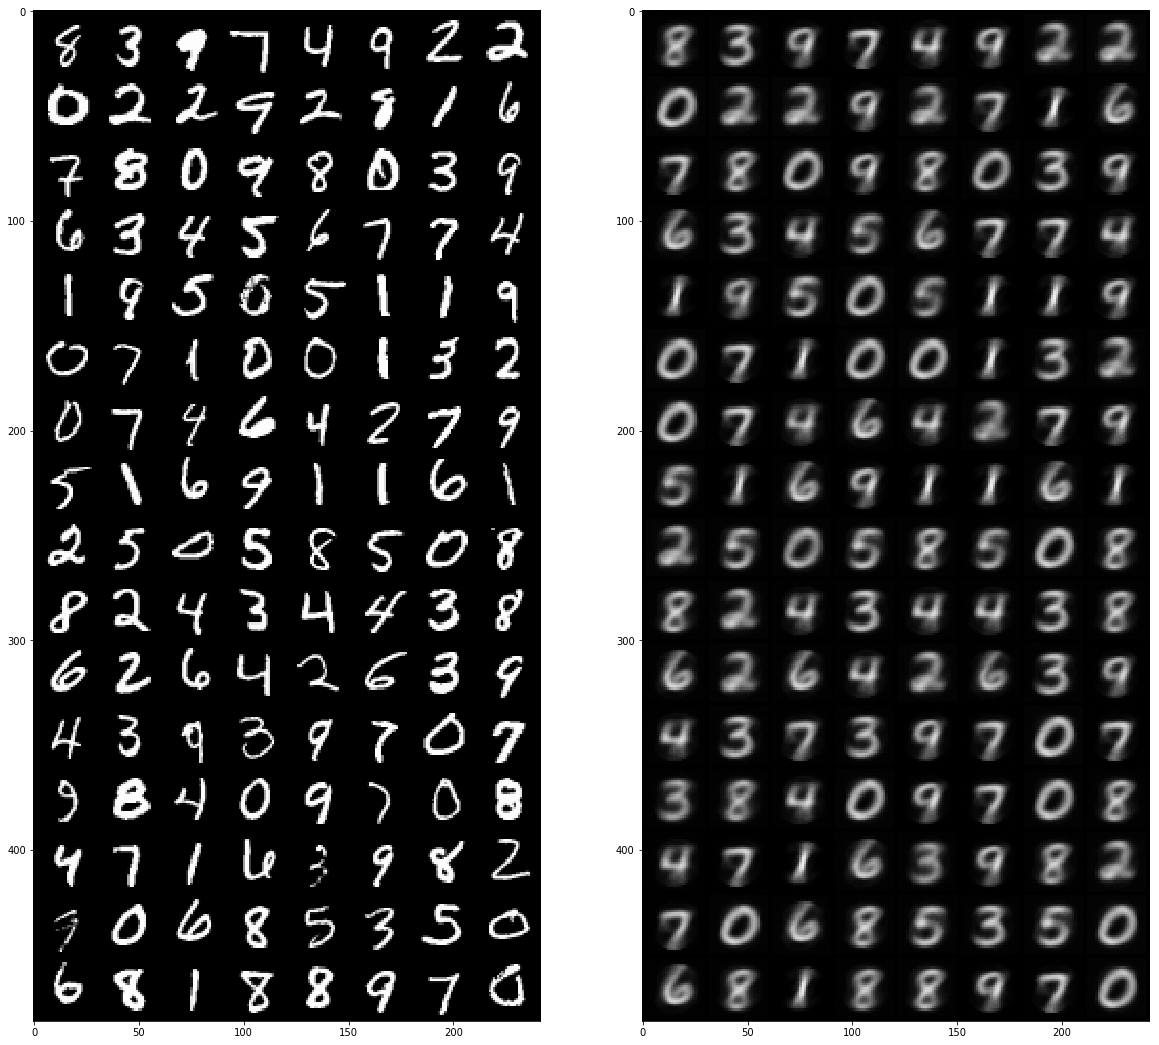

In [32]:
out = encoder(x.cuda())
out_m = torch.norm(out, dim=-1).cuda()
_, v_max_index = out_m.max(dim=1)
v_max_index = v_max_index.data

y = torch.eye(10).cuda()
y = y.index_select(dim=0, index=v_max_index).unsqueeze(2)
masked = (out*y).view(out.size(0), -1)

res = decoder(masked)

t1 = vutils.make_grid(x).cpu().numpy().transpose(1,2,0)
t2 = vutils.make_grid(res.detach()).cpu().numpy().transpose(1,2,0)

fig, arr = plt.subplots(1,2,figsize=(20,20))
arr[0].imshow(t1)
arr[1].imshow(t2)
plt.show()

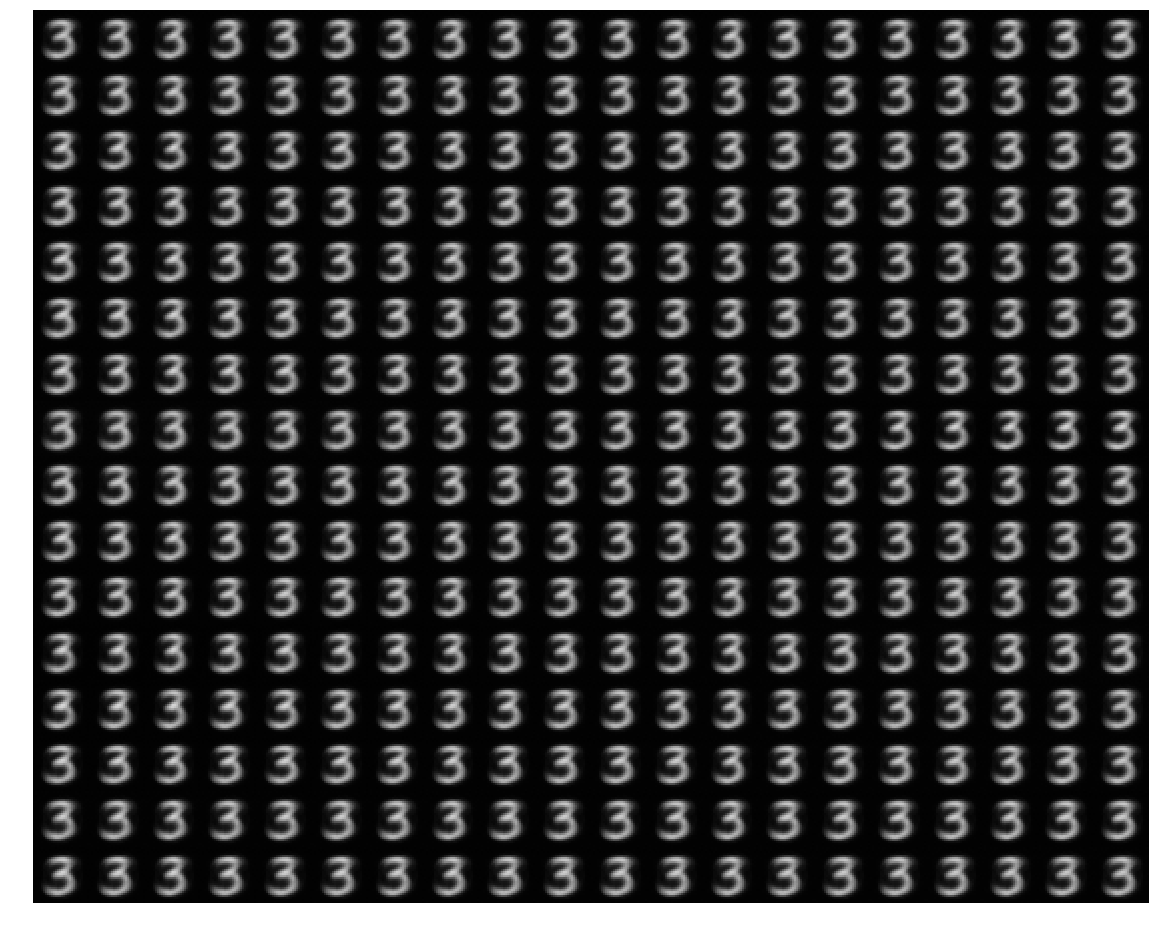

In [28]:
import copy

single_x = x[10]
single_x = single_x[None, :, :]
out = encoder(single_x.cuda())
out_m = torch.norm(out, dim=-1).cuda()
_, v_max_index = out_m.max(dim=1)
v_max_index = v_max_index.data

y = torch.eye(10).cuda()
y = y.index_select(dim=0, index=v_max_index).unsqueeze(2)
masked = (out*y)
masked = masked.detach()

imgs = np.zeros((320, 28, 28, 3))

count = 0
for dim in range(16):
    for n in np.arange(-.1, .1, 0.01):
        mod_masked = copy.deepcopy(masked.cpu().numpy())
        mod_masked[:, :, dim] += n

        mod_masked = torch.from_numpy(mod_masked).cuda()
        mod_masked = mod_masked.view(out.size(0), -1)

        res = decoder(mod_masked)
        t2 = vutils.make_grid(res.detach()).cpu().numpy().transpose(1,2,0)
        imgs[count] = t2
        count += 1

plot_montage(imgs, 16, 20)
    